In [1]:
import sys
sys.path.append("../utils")
from utils import load_data, load_cgc_data
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Import Keras for implementing autoencoders
import keras
from keras.models import Sequential
from keras.layers import Input, Dense
from pathlib import Path
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from vae import create_ae_model

2024-12-03 12:00:37.799209: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Can be used with both CGC and non CGC column selection 
Be careful with the comments

In [3]:
#train_data, test_data, train_target = load_data(raw = False, categorical=False)
train_data, test_data, train_target = load_cgc_data()

In [4]:
nb_cell_lines = train_data.shape[0]
print("Number of cell lines: ", nb_cell_lines)

Number of cell lines:  742


In [5]:
# Split the data 
X_train, X_test, y_train, y_test = train_test_split(train_data, train_target, test_size=0.2, random_state=42)

In [6]:
# Parameters
input_dim = X_train.shape[1]
latent_dim = 50  # Adjust the latent dimension as needed
num_trials = 100  # Number of times to train the autoencoder
best_spearman = -float('inf')
best_model = None
best_encoded_features_train = None
best_encoded_features_test = None

Training Trial 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Trial 1 - Spearman's Correlation (ρ): 0.2532
New best Spearman's Correlation (ρ) achieved: 0.2532
Training Trial 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Trial 2 - Spearman's Correlation (ρ): 0.3694
New best Spearman's Correlation (ρ) achieved: 0.3694
Training Trial 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Trial 3 - Spearman's Correlation (ρ): 0.3224
Training Trial 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Trial 4 - Spearman's Correlation (ρ): 0.3049
Training Trial 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Trial 5 - Spearman's Correlation (ρ): 0.3115
Training Trial 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Trial 6 - Spearman's Correlation (ρ): 0.3266
Training Trial 7/100
19/19 ━━━━━━━━

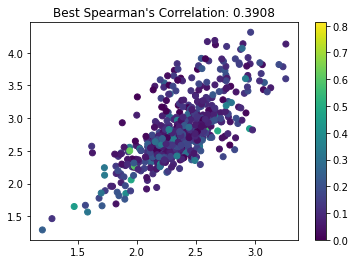

In [7]:
for trial in range(num_trials):
    print(f"Training Trial {trial + 1}/{num_trials}")
    
    # Create and train autoencoder
    autoencoder = create_ae_model(input_dim=input_dim, latent_dim=latent_dim)
    autoencoder.fit(X_train, X_train, epochs=20, batch_size=32, shuffle=True, validation_data=(X_test, X_test), verbose=0)
    
    # Use encoder part of the autoencoder for feature extraction
    encoder = keras.Model(inputs=autoencoder.input, outputs=autoencoder.layers[1].output)
    encoded_features_train = encoder.predict(X_train)
    encoded_features_test = encoder.predict(X_test)
    
    # Fit a linear regression model using the encoded features
    encoded_model = LinearRegression()
    encoded_model.fit(encoded_features_train, y_train)
    
    # Make predictions on the test set
    y_pred_encoded = encoded_model.predict(encoded_features_test)
    
    # Calculate regression metrics
    mse_encoded = mean_squared_error(y_test, y_pred_encoded)
    r2_encoded = r2_score(y_test, y_pred_encoded)
    
    # Calculate Spearman's rank correlation
    spearman_encoded, p_value_encoded = spearmanr(y_test, y_pred_encoded)
    
    print(f"Trial {trial + 1} - Spearman's Correlation (ρ): {spearman_encoded:.4f}")
    
    # Track the best model
    if spearman_encoded > best_spearman:
        print(f"New best Spearman's Correlation (ρ) achieved: {spearman_encoded:.4f}")
        best_spearman = spearman_encoded
        best_model = autoencoder
        best_encoded_features_train = encoded_features_train
        best_encoded_features_test = encoded_features_test

# Print the best Spearman's correlation
print(f"Best Spearman's Correlation (ρ) achieved: {best_spearman:.4f}")

# Plot the best latent features
plt.scatter(best_encoded_features_train[:, 0], best_encoded_features_train[:, 1], c=y_train['AAC'], cmap='viridis')
plt.colorbar()
plt.title(f"Best Spearman's Correlation: {best_spearman:.4f}")
plt.show()

In [8]:
# Encode the entire data set and save the encoded features
encoder = keras.Model(inputs=best_model.input, outputs=best_model.layers[1].output)
# Add the project root directory to the Python path
project_root = Path().resolve().parent.parent
sys.path.append(str(project_root))
# Load the data
data_path = project_root / 'data' / 'encoded'
total_data = pd.concat([train_data, test_data])
encoded_features = encoder.predict(total_data)
print(encoded_features.shape)
encoded_features = pd.DataFrame(encoded_features, columns=["encoded_feature_" + str(i) for i in range(encoded_features.shape[1])])
#encoded_features.to_csv(data_path / 'ae_data.csv', index=False)
encoded_features.to_csv(data_path / 'ae_cgc_data.csv', index=False)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
(1046, 50)


# VAE

In [9]:
from src.utils.vae import VAE, train, plot_latent_space, load_vae_model, save_vae_model
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

Training Trial 1/100
Epoch 1/10, Train Loss: 2.7428, Val Loss: 0.3011
Epoch 2/10, Train Loss: 0.1833, Val Loss: 0.0956
Epoch 3/10, Train Loss: 0.0649, Val Loss: 0.0381
Epoch 4/10, Train Loss: 0.0298, Val Loss: 0.0236
Epoch 5/10, Train Loss: 0.0198, Val Loss: 0.0181
Epoch 6/10, Train Loss: 0.0154, Val Loss: 0.0149
Epoch 7/10, Train Loss: 0.0128, Val Loss: 0.0128
Epoch 8/10, Train Loss: 0.0108, Val Loss: 0.0116
Epoch 9/10, Train Loss: 0.0096, Val Loss: 0.0103
Epoch 10/10, Train Loss: 0.0084, Val Loss: 0.0093
(593, 50)
--- VAE Encoded Features ---
Mean Squared Error (MSE): 0.006308833607412964
R-squared (R²): 0.1572580292910054
Spearman's Correlation (ρ): 0.31246899371407166
Model saved at /Users/Oskar/Desktop/Uni_Work/EPFL/Neuro-X/MA1/ML/projet_2/ml-project-2-lol-ml/models/vae/vae_model_0_3125.pth
Training Trial 2/100
Epoch 1/10, Train Loss: 2.7961, Val Loss: 0.2534
Epoch 2/10, Train Loss: 0.1597, Val Loss: 0.0818
Epoch 3/10, Train Loss: 0.0594, Val Loss: 0.0370
Epoch 4/10, Train Loss: 0

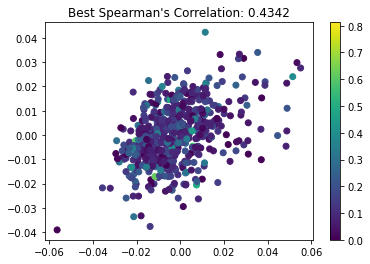

In [10]:
# Use VAE for feature selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert to tensor
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
dataset = TensorDataset(X_train_tensor)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
test_dataset = TensorDataset(X_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

input_dim = X_train.shape[1]
latent_dim = 50
num_trials = 100  # Number of times to train the model and select the best one
best_spearman = -float('inf')
best_model_state = None
best_latent_train = None
best_latent_test = None

for trial in range(num_trials):
    print(f"Training Trial {trial + 1}/{num_trials}")
    model = VAE(input_dim=input_dim, latent_dim=latent_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    train(model, train_loader, test_loader, optimizer, epochs=10, device=device)
    
    # Extract latent features from X_train
    latent_train, _ = model.encode(X_train_tensor)
    latent_test, _ = model.encode(X_test_tensor)
    latent_train = latent_train.detach().numpy()
    latent_test = latent_test.detach().numpy()
    print(latent_train.shape) 
    
    # Train a linear regression model on the encoded features
    vae_encoded_model = LinearRegression()
    vae_encoded_model.fit(latent_train, y_train)
    y_pred_vae = vae_encoded_model.predict(latent_test)
    
    # Calculate regression metrics
    mse_vae = mean_squared_error(y_test, y_pred_vae)
    r2_vae = r2_score(y_test, y_pred_vae)
    spearman_vae, p_value_vae = spearmanr(y_test, y_pred_vae)

    # Print the results
    print("--- VAE Encoded Features ---")
    print("Mean Squared Error (MSE):", mse_vae)
    print("R-squared (R²):", r2_vae)
    print("Spearman's Correlation (ρ):", spearman_vae)

    # Track the best model based on Spearman's correlation
    if spearman_vae > best_spearman:
        best_spearman = spearman_vae
        save_vae_model(model, best_spearman)
        best_latent_train = latent_train
        best_latent_test = latent_test
        


print(f"Best Spearman's Correlation (ρ) achieved: {best_spearman:.4f}")
# Plot only the best latent features
plt.scatter(best_latent_train[:, 0], best_latent_train[:, 1], c=y_train['AAC'], cmap='viridis')
plt.colorbar()
plt.title(f"Best Spearman's Correlation: {best_spearman:.4f}")
plt.show()

In [12]:
total_data = pd.concat([train_data, test_data])
total_data_tensor = torch.tensor(total_data.values, dtype=torch.float32)
best_model = load_vae_model(file_name='vae_cgc_model_0_4342.pth')
encoded_features,_ = best_model.encode(total_data_tensor)
project_root = Path().resolve().parent.parent
sys.path.append(str(project_root))
# Load the data
data_path = project_root / 'data' / 'encoded'
encoded_features = pd.DataFrame(encoded_features.detach().numpy(), columns=["encoded_feature_" + str(i) for i in range(encoded_features.shape[1])])
#encoded_features.to_csv(data_path / 'vae_data.csv', index=False)
encoded_features.to_csv(data_path / 'vae_cgc_data.csv', index=False)

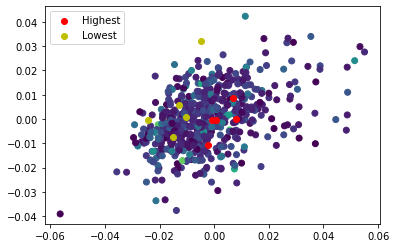

In [30]:
# PLot the 5 values with the highest and lowest values of AAC
# Sort the predictions
sorted_indices = np.argsort(y_train['AAC'].values)
# Get the 5 highest and lowest values
highest_indices = sorted_indices[-5:]
lowest_indices = sorted_indices[:5]
latent_x = 0
latent_y = 1
# Plot the values in latent space
plt.scatter(best_latent_train[:, latent_x], best_latent_train[:, latent_y], c=y_train['AAC'], cmap='viridis')
plt.scatter(latent_train[highest_indices, latent_x], latent_train[highest_indices, latent_y], c='r', label='Highest')
plt.scatter(latent_train[lowest_indices, latent_x], latent_train[lowest_indices, latent_y], c='y', label='Lowest')
plt.legend()
plt.show()
